# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Изучение файла <a name="1"></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
df.head(8)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0


Все данные числовые. Последний столбец "is_ultra" - целевой признак, 1 - тариф Ультра, 0 - тариф Смарт. В остальных столбцах - признаки.

In [4]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Очень большая разница в соотношении категорий. Тариф смарт явно лидирует. Поэтому лучше дополнительно использовать в анализе такие метрики как precision и recall. Recall демонстрирует способность алгоритма обнаруживать данную категорию вообще, а precision — способность отличать эту категорию от других категорий.

## Разобьем данные на выборки <a name="2"></a>

Разобём данные на признаки и целевой признак.

In [5]:
features = df.drop('is_ultra', axis=1).copy()
target = df['is_ultra'].copy()

Далее разобьем данные на обучающую, валидационную и тестовые выборки. Исходные данные разобьем в соотношении 3:1:1. Размеры тестовой и валидационной выборки обычно равны.

In [6]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4,\
                                                                              random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5,\
                                                                              random_state=12345, stratify=target_valid)

Проверим размер выборок.

In [7]:
print('Размер таблицы признаков обучающей выборки', features_train.shape[0])
print('Размер таблицы целевого признаков обучающей выборки', target_train.shape[0])
print('----------------------------------------------------')
print('Размер таблицы признаков валидационной выборки', features_valid.shape[0])
print('Размер таблицы целевого признаков валидационной выборки', target_valid.shape[0])
print('----------------------------------------------------')
print('Размер таблицы признаков тестовой выборки', features_test.shape[0])
print('Размер таблицы целевого признаков тестовой выборки', target_test.shape[0])

Размер таблицы признаков обучающей выборки 1928
Размер таблицы целевого признаков обучающей выборки 1928
----------------------------------------------------
Размер таблицы признаков валидационной выборки 643
Размер таблицы целевого признаков валидационной выборки 643
----------------------------------------------------
Размер таблицы признаков тестовой выборки 643
Размер таблицы целевого признаков тестовой выборки 643


## Исследуем модели <a name="3"></a>

### Обучим модель с помощью дерева решений.

Таблица соответствия качества предсказаний, глубины решающего дерева и дополнительно метрики precision и recall


,accuracy,depth,precision,recall
0,0.740280,1,0.692308,0.274112
1,0.772939,2,0.697674,0.456853
2,0.777605,3,0.741071,0.421320
3,0.754277,4,0.767123,0.284264
4,0.785381,5,0.736000,0.467005
5,0.774495,6,0.745283,0.401015
6,0.786936,7,0.777778,0.426396
7,0.802488,8,0.769231,0.507614
8,0.782271,9,0.728000,0.461929
9,0.772939,10,0.694656,0.461929


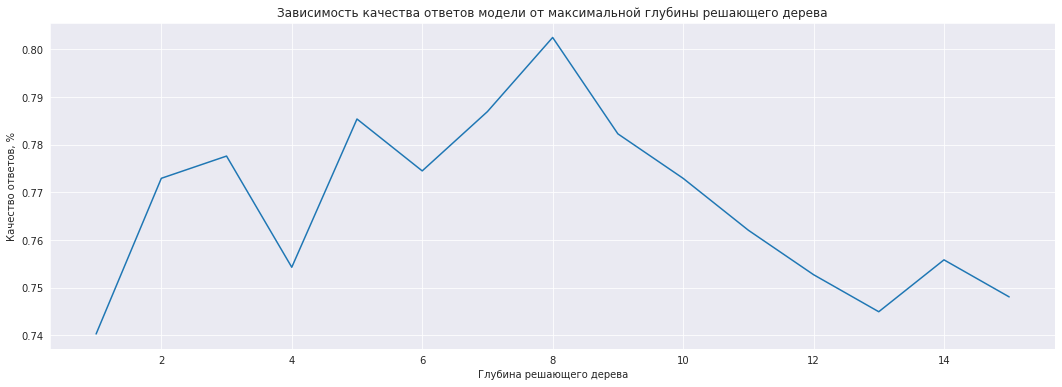

Самая лучшая модель по качеству предсказаний:
    accuracy  depth  precision    recall
6   0.786936      7   0.777778  0.426396
7   0.802488      8   0.769231  0.507614
13  0.755832     14   0.611111  0.558376


In [16]:
accu = [] # переменная, где будем хранить правильность (качество) наших моделей
dep = [] # переменная, где будем хранить глубину решающих деревьев наших моделей
prec = [] # precision
reca = [] # recall
for depth in range(1,16):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accu_score = accuracy_score(target_valid, predictions)
    precision = precision_score(target_valid, predictions)
    recall = recall_score(target_valid, predictions)
    accu.append(accu_score)
    dep.append(depth)
    prec.append(precision)
    reca.append(recall)
accu_dep = [] # датафрейм с accuracy, depth, estimators, precision и recall
accu_dep = pd.DataFrame({'accuracy':accu, 'depth': dep, 'precision': prec, 'recall': reca})
print('Таблица соответствия качества предсказаний, глубины решающего дерева и дополнительно метрики precision и recall')
display(accu_dep)
plt.figure(figsize=(18, 6))
sns.set_style("darkgrid")
sns.lineplot(x="depth", y="accuracy", data=accu_dep);
plt.title('Зависимость качества ответов модели от максимальной глубины решающего дерева')
plt.xlabel('Глубина решающего дерева')
plt.ylabel('Качество ответов, %')
plt.show()
print('Лучшие модели:')
print(accu_dep[(accu_dep['accuracy'] == accu_dep['accuracy'].max()) | \
                    (accu_dep['precision'] == accu_dep['precision'].max()) | \
                    (accu_dep['recall'] == accu_dep['recall'].max())])

По графику видно, что наилучшее качество предсказаний достигается с параметром максимальной глубины дерева, равному 8. При этом precision(точность, способность отличать категории: одну от другой) достаточно высока, лишь на 0,8% отличается от наивысшей. И recall(полнота) в данном случае на 5% ниже самой большого показателя. После глубины 9 качество предсказаний начинает снижаться.

### Далее используем алгоритм "Случайный лес"

Таблица соответствия метрик качества предсказаний, глубины решающего дерева и количества деревьев


,accuracy,depth,estimators,precision,recall
0,0.757387,1,10,0.805970,0.274112
1,0.755832,1,15,0.822581,0.258883
2,0.730949,1,20,0.900000,0.137056
3,0.730949,1,25,0.900000,0.137056
4,0.729393,1,30,0.870968,0.137056
...,...,...,...,...,...
130,0.791602,15,30,0.711409,0.538071
131,0.802488,15,35,0.736486,0.553299
132,0.799378,15,40,0.736111,0.538071
133,0.799378,15,45,0.736111,0.538071


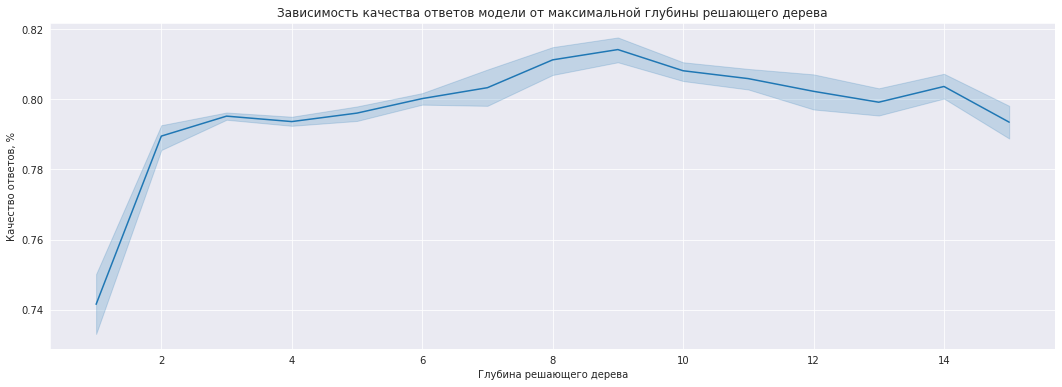

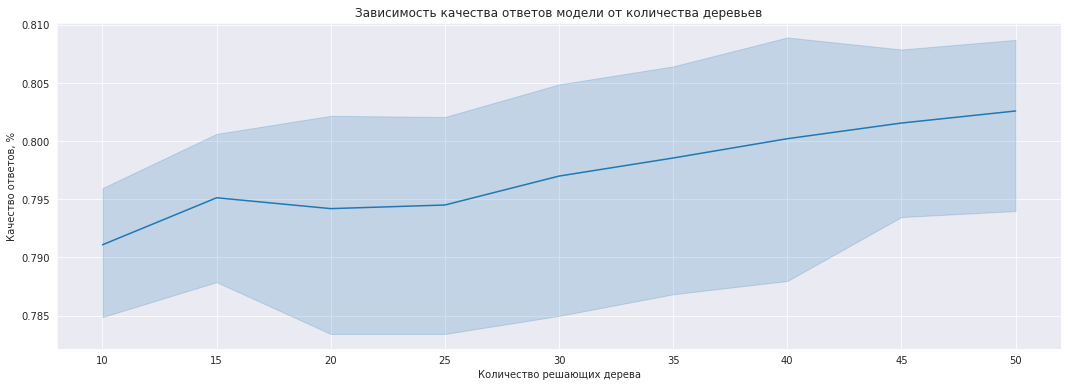

Самая лучшая модель по качеству предсказаний:
     accuracy  depth  estimators  precision    recall
2    0.730949      1          20   0.900000  0.137056
3    0.730949      1          25   0.900000  0.137056
78   0.821151      9          40   0.810606  0.543147
106  0.810264     12          45   0.755102  0.563452
118  0.807154     14          15   0.744966  0.563452


In [9]:
accu = [] # accuracy
dep = [] #depth
estim = [] # estimators
prec = [] # precision
reca = [] # recall
for depth in range (1, 16):
    for est in range(10, 51, 5):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        accu_score = accuracy_score(target_valid, predictions)
        precision = precision_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
        accu.append(accu_score)
        dep.append(depth)
        estim.append(est)
        prec.append(precision)
        reca.append(recall)
accu_dep_estim = [] # датафрейм с accuracy, depth, estimators, precision и recall
accu_dep_estim = pd.DataFrame({'accuracy':accu, 'depth': dep, 'estimators': estim, 'precision': prec, 'recall': reca})
print('Таблица соответствия качества предсказаний, глубины решающего дерева и дополнительно метрики precision и recall')
display(accu_dep_estim)
# построим график зависимости качества ответов модели от максимальной глубины решающего дерева
plt.figure(figsize=(18, 6))
sns.set_style("darkgrid")
sns.lineplot(x="depth", y="accuracy", data=accu_dep_estim);
plt.title('Зависимость качества ответов модели от максимальной глубины решающего дерева')
plt.xlabel('Глубина решающего дерева')
plt.ylabel('Качество ответов, %')
plt.show()
# построим график зависимости качества ответов модели от количества деревьев
plt.figure(figsize=(18, 6))
sns.set_style("darkgrid")
sns.lineplot(x="estimators", y="accuracy", data=accu_dep_estim);
plt.title('Зависимость качества ответов модели от количества деревьев')
plt.xlabel('Количество решающих дерева')
plt.ylabel('Качество ответов, %')
plt.show()
print('Лучшие модели:')
print(accu_dep_estim[(accu_dep_estim['accuracy'] == accu_dep_estim['accuracy'].max()) | \
                    (accu_dep_estim['precision'] == accu_dep_estim['precision'].max()) | \
                    (accu_dep_estim['recall'] == accu_dep_estim['recall'].max())])

С этим алгоритмом наши предсказания стали немного выше на 2%. Этого удалось достичь, используя параметры: максимальная глубина 9 и количество деревьев 40. При этом точность составляет 81%, но наивысшая 90%. А при 90% точности доля правильных ответов на 9% ниже и крайне низкая полнота(всего 13,7%). Поэтому мы выбрали золотую середину.

### Используем алгоритм логистической регрессии

In [17]:
model = LogisticRegression(random_state=12345, solver='lbfgs')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accu_score = accuracy_score(target_valid, predictions)
precision = precision_score(target_valid, predictions)
recall = recall_score(target_valid, predictions)
print('Качество предсказаний модели по алгоритму логистической регрессии:', accu_score)
print('Точность предсказаний модели по алгоритму логистической регрессии:', precision)
print('Полнота предсказаний модели по алгоритму логистической регрессии:', recall)

Качество предсказаний модели по алгоритму логистической регрессии: 0.7387247278382582
Точность предсказаний модели по алгоритму логистической регрессии: 0.8085106382978723
Полнота предсказаний модели по алгоритму логистической регрессии: 0.19289340101522842


Качество предсказаний намного ниже у логистической регрессии, чем у решающего дерева и случайного леса. Точность достаточно высокая, но полнота очень низкая. То есть способность алгоритма обнаруживать данную категорию вообще лишь 20%.

В результате наилучший процент (82%) правильных предсказаний мы получили, используя алгоритм "Случайный лес" с параметрами - максимальная глубина 9 и количество деревьев 40.

## Проверим модель на тестовой выборке <a name="4"></a>

In [11]:
model = RandomForestClassifier(random_state=12345, max_depth=8, n_estimators=40)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('% правильных предсказаний на тестовых данных:', accuracy_score(target_test, predictions))

% правильных предсказаний на тестовых данных: 0.8087091757387247


Нам удалось добиться желаемого % правильных предсказаний в 75%. Наша модель показала на тестовых данных 80,9% правильных предсказаний.

## Проверим модель на адекватность <a name="5"></a>

Проверим модель на адекватность, используя простейшую модель DummyClassifier, которая предсказывает наиболее часто встречающийся класс

In [12]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_clf.fit(features_train, target_train)
print('% правильных предсказаний самой простой моделью', dummy_clf.score(features_test, predictions))

% правильных предсказаний самой простой моделью 0.776049766718507


Результат простейшей модели на 4,5% хуже нашей, значит наша модель адекватная.

Посмотрим как распределены тарифы в исходных данных.

In [13]:
print(df['is_ultra'].value_counts(normalize=True))

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64


Если в 100% случаев выбирать тариф смарт, то качество предсказаний составило бы 69%. На фоне этого процента наша модель выглядит еще адекватнее. А если только тариф ультра, то качество предсказаний составило бы 31%.